In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import matplotlib.pyplot as plt

import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

import spacy
from tqdm.gui import tqdm_gui

In [97]:
colomn = ['text','sentiment',0]
data = pd.read_csv('Roman Urdu DataSet.csv', names=colomn,header=None)

In [98]:
data.head()

,text,sentiment,0
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


In [99]:
data.drop([0],inplace=True,axis=1)

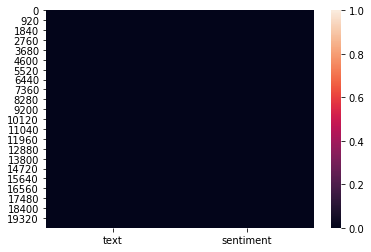

In [100]:
sns.heatmap(data.isnull())

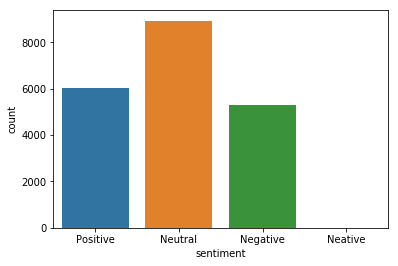

In [101]:
sns.countplot(x='sentiment',data=data)


In [102]:

SAFE_DIV = 0.0001 



def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("bt", "but").replace("MASHA'ALLAH", "mashallah").replace("INSHA'ALLAH", "inshallah")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"http\S+", "", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [103]:
 data['text']=data['text'].apply(lambda  x: preprocess(x))



In [104]:
data['sentiment'].replace(to_replace='Positive',value=1,inplace=True)
data['sentiment'].replace(to_replace='Neutral',value=3,inplace=True)
data['sentiment'].replace(to_replace='Neative',value=0,inplace=True)
data['sentiment'].replace(to_replace='Negative',value=0,inplace=True)



In [15]:
import  tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback,EarlyStopping


In [16]:
vocab_size=10000
embedding_dim = 16
max_length= 100

In [17]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token='oov-token')

In [18]:
tokenizer = Tokenizer(num_words=max_length, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X,maxlen=max_length,    truncating='post')

In [19]:
Y = pd.get_dummies(data['sentiment']).values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(13553, 100) (13553, 3)
(6676, 100) (6676, 3)


In [282]:

X.shape[1]

100

In [141]:
traing_sent = data['text'][:16000]
test_sent = data['text'][16000:]

In [142]:
traing_label = data['sentiment'][:16000]
test_label = data['sentiment'][16000:]

In [223]:
from keras.utils import np_utils
traing_label = np_utils.to_categorical(traing_label)
test_label=np_utils.to_categorical(test_label)


In [72]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length = X.shape[1]),
    
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

      
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Flatten(),
    
    #tf.keras.layers.LSTM(128),
  #tf.keras.layers.LSTM(200,activation='relu',return_sequences=True),
   #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),


        tf.keras.layers.Dropout(0.2),




    tf.keras.layers.Dense(3,activation='softmax')
                                  ])

In [73]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          41472     
_________________________________________________________________
lstm_50 (LSTM)               (None, 256)               394240    
_________________________________________________________________
flatten_25 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_81 (Dropout)         (None, 128)             

In [74]:
num_epochs = 50


earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop ]




history = model.fit(X_train, Y_train, callbacks = callbacks,epochs=num_epochs, validation_data=(X_test,Y_test))

Epoch 1/50
424/424 [==============================] - 232s 548ms/step - loss: 1.0432 - accuracy: 0.4772 - val_loss: 1.0311 - val_accuracy: 0.5027
Epoch 2/50
424/424 [==============================] - 235s 555ms/step - loss: 1.0169 - accuracy: 0.5058 - val_loss: 1.0085 - val_accuracy: 0.5084
Epoch 3/50
424/424 [==============================] - 231s 546ms/step - loss: 1.0033 - accuracy: 0.5178 - val_loss: 0.9909 - val_accuracy: 0.5261
Epoch 4/50
424/424 [==============================] - 231s 544ms/step - loss: 0.9902 - accuracy: 0.5310 - val_loss: 0.9726 - val_accuracy: 0.5357
Epoch 5/50
424/424 [==============================] - 231s 545ms/step - loss: 0.9812 - accuracy: 0.5357 - val_loss: 0.9788 - val_accuracy: 0.5316
Epoch 6/50
424/424 [==============================] - 309s 728ms/step - loss: 0.9746 - accuracy: 0.5390 - val_loss: 0.9670 - val_accuracy: 0.5339
Epoch 7/50
424/424 [==============================] - 299s 706ms/step - loss: 0.9709 - accuracy: 0.5386 - val_loss: 0.9703 -

In [75]:
twt = ['bura insaan hai vo par dil ka saaf hai']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=max_length, truncating='post')

sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 - 0s


In [76]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

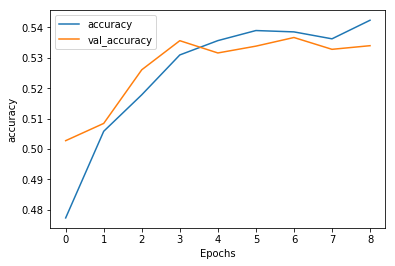

In [77]:
plot_graphs(history, 'accuracy')

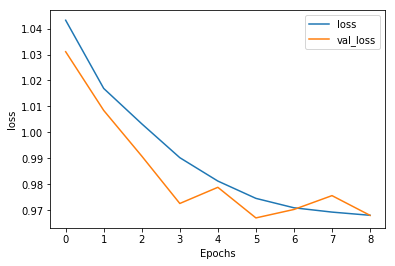

In [78]:
plot_graphs(history, 'loss')


In [83]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}


In [108]:
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.33, random_state=42)

In [110]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.6746    0.4375    0.5308      1744
           1     0.6417    0.6433    0.6425      1954
           3     0.6339    0.7633    0.6926      2978

   micro avg     0.6430    0.6430    0.6430      6676
   macro avg     0.6500    0.6147    0.6219      6676
weighted avg     0.6468    0.6430    0.6356      6676

